# Stochastic volatility model

Notebook for the check of gradients

### Mount Drive

In [ ]:
# mount my drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following path has to be adjusted if necessary:

In [ ]:
%run "/content/drive/My Drive/Colab Notebooks/Utils.ipynb"
%run "/content/drive/My Drive/Colab Notebooks/Plot_fcts.ipynb"

### Imports

In [ ]:
! pip install qmcpy --quiet

In [ ]:
import numpy as np
import qmcpy
from copy import deepcopy

### Sampling

In [ ]:
np.random.seed(111)

Set parameters:

In [ ]:
m = 600                                   # number of simulated samples
n = 300                                   # number of true samples
theta = np.array([0.98,0.65,0.15])        # true theta
d = 30                                    # dimensions of data
p = theta.shape[0]                        # dimensions of parameter space
l = -1                                    # lengthscale (l=-1 for median heuristic)

Define QMC sequence:

In [ ]:
qmc = qmcpy.Halton(2+2*d)

Sample from the g-and-k distribution:

In [ ]:
y,_,_ = sample_sv('MC',m,d,theta)
x,h,u = sample_sv('MC',n,d,theta)

Plot samples and generator:

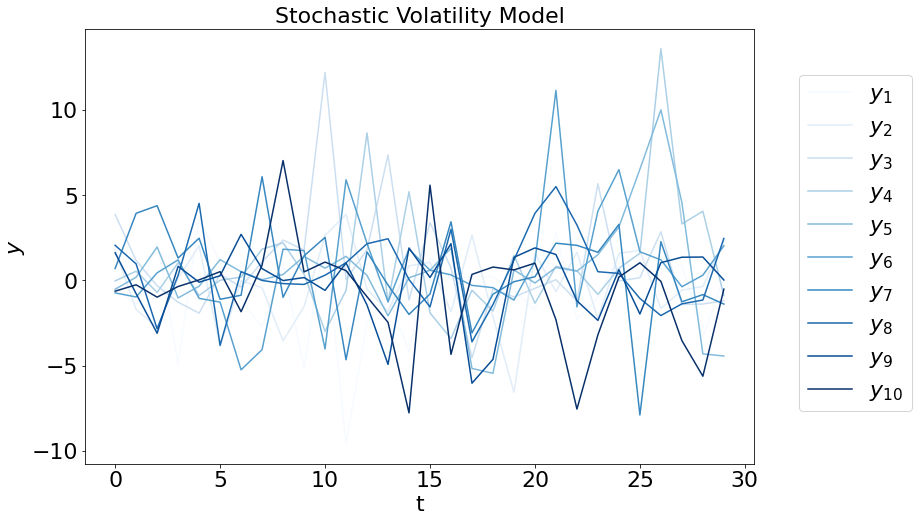

In [ ]:
plot_sv(y,(12,8))

### Check generator gradient

In [ ]:
print('gradient of the generator:')
grad_gen_sv(u,h,x,theta)[:,:,0]

gradient of the generator:


array([[ 1.410e+00,  4.355e+00,  1.140e+00],
       [-1.207e-01, -3.400e-01,  1.514e-01],
       [ 1.699e-01, -8.835e-01, -5.212e-03],
       ...,
       [ 7.805e-02,  6.710e-01,  4.232e-02],
       [ 6.851e-01,  6.658e+00,  2.556e+00],
       [ 2.596e-01,  7.389e-01,  3.047e-01]])

In [ ]:
# check gradient
par = 0
dim = 20
theta_check = deepcopy(theta)
theta_check[par] = theta_check[par] + 0.00000001
x_check,_= gen_sv(u, theta_check)

In [ ]:
print('check gradient using finite differences:')
print((gen_sv(u, theta_check)[0][0,dim]-gen_sv(u,theta)[0][0,dim])/0.00000001)
print(grad_gen_sv(u,h,x,theta)[dim,par,0])

check gradient using finite differences:
1.1522596432556043
1.1522596159996912


### Check kernel

In [ ]:
kxx = k(x,x,l)
kxy = k(x,y,l)
kyy = k(y,y,l)
k1xx = kxx[1]
k1xy = kxy[1]
k21xx = kxx[2]

In [ ]:
print('kernel:')
print(kxy[0][1,1])
print('\nderivative w.r.t. the first element:')
print(kxy[1][:,1,1])
print('\nderivative w.r.t. the second and first element:')
print(kxy[2][:,:,1,1])

kernel:
1.4313238187514323e-125

derivative w.r.t. the first element:
[-3.750e-126  2.988e-126  1.832e-125 ...  9.759e-125  1.332e-124
  8.150e-126]

derivative w.r.t. the second and first element:
[[ 1.333e-125  7.828e-127  4.800e-126 ...  2.557e-125  3.489e-125
   2.135e-126]
 [ 7.828e-127  1.369e-125 -3.825e-126 ... -2.037e-125 -2.780e-125
  -1.701e-126]
 [ 4.800e-126 -3.825e-126 -9.142e-126 ... -1.249e-124 -1.705e-124
  -1.043e-125]
 ...
 [ 2.557e-125 -2.037e-125 -1.249e-124 ... -6.511e-124 -9.079e-124
  -5.557e-125]
 [ 3.489e-125 -2.780e-125 -1.705e-124 ... -9.079e-124 -1.225e-123
  -7.582e-125]
 [ 2.135e-126 -1.701e-126 -1.043e-125 ... -5.557e-125 -7.582e-125
   9.673e-126]]


In [ ]:
#check derivatives using finite differences
print('check first derivative w.r.t. the first element:')
print((k(x+0.00000001,y,l)[0][1,1]-kxy[0][1,1])/0.00000001)
print(np.sum(kxy[1][:,1,1]))
print('\ncheck second derivative w.r.t. the second and first element:')
print((-k(x+0.00000001,y,l)[1][:,1,1]+kxy[1][:,1,1])/0.00000001)
print(np.sum(kxy[2][:,:,1,1],axis=0))

check first derivative w.r.t. the first element:
4.161803160064542e-124
4.161803130762815e-124

check second derivative w.r.t. the second and first element:
[ 1.233e-124 -7.257e-125 -5.185e-124 ... -2.823e-123 -3.858e-123
 -2.226e-124]
[ 1.233e-124 -7.257e-125 -5.185e-124 ... -2.823e-123 -3.858e-123
 -2.226e-124]


### Check the MMD$^2$ gradient $\hat{J}$

In [ ]:
print('MMD^2 approximation:')
MMD_approx(n,m,kxx[0],kxy[0],kyy[0])

MMD^2 approximation:


2.4352613846420572e-17

In [ ]:
grad_g = grad_gen_sv(u,h,x,theta)
print('gradient of the MMD^2 approximation:')
grad_MMD(p,n,m,grad_g,k1xx,k1xy)

gradient of the MMD^2 approximation:


array([ 1.968e-18,  6.752e-17, -2.774e-19])

In [ ]:
# check gradient using finite differences
par = 2
theta_check = deepcopy(theta)
theta_check[par] = theta_check[par] + 0.00000001
x_check,_ = gen_sv(u,theta_check)
print('check gradient of the MMD^2 approximation:')
print((MMD_approx(n,m,k(x_check,x_check,l)[0],k(x_check,y,l)[0],kyy[0])-MMD_approx(n,m,kxx[0],kxy[0],kyy[0]))/0.00000001)
print(grad_MMD(p,n,m,grad_g,k1xx,k1xy)[par])

check gradient of the MMD^2 approximation:
2.0349021421285767e-18
-2.7742040249746327e-19


### Test information metric $g_U(\theta)$

In [ ]:
# test function
print('approximation of information metric g:')
g_approx(p,n,grad_g,k21xx)

approximation of information metric g:


array([[-7.222e-18,  1.326e-01,  3.391e-02],
       [ 1.326e-01, -3.168e-16,  2.124e-01],
       [ 3.391e-02,  2.124e-01, -1.384e-17]])